# Split & Merge image segmentation - Podavini Luca - Signals, Images and Videos 
# Introduction

Split & Merge is a *region-based* image segmentation technique that combines both top-down and bottom-up approaches. The process begins by recursively splitting the image into four smaller regions based on a homogeneity criterion. Then, when the splitting phase is complete, adjacent regions are merged to form larger homogeneous regions, resulting in the final segmented image.

The splitting phase is usually made using a quad-tree data structure. The merge part is instead made using a data structure called RAG (Region Adjacency Graph). It keeps track of which regions are adjacent to each other, associating a cost to each link. During the execution of the algorithm, we always merge the two regions with the lowest cost (loss of homogeneity).

The goal of this project is to code my own version of the Split & Merge algorithm, in order to learn understand how it works and its characteristics. This report discusses various aspects of the algorithm's implementation, addressing the main difficulties encountered during development and how they were addressed. It also includes a study on the algorithm's complexity, focusing on the data structures that have been used.

# 1. Environment setup
The Split & Merge algorithm needs some external library, the main ones are ```opencv``` for the image processing part and ```numpy``` for the statistical computations. Some other important libraries are ```sortedcontainers```, a data-structure used for the RAG implementation and ```matplotlib``` is used for displaying the results. 

The requirements of the projects are written in the ```environment.yml``` file, used during the conda environment initialization:

```
name: split_and_merge
channels:
  - conda-forge
dependencies:
  - pip
  - python=3.12.5
  - opencv=4.10.0
  - jupyter
  - ipykernel
  - numpy
  - matplotlib
  - sortedcontainers
```
The following code shows all the libraries imported into the code. They are divided into groups based on where they are required: some are only needed within the notebook to display the results, others have been reported for illustrative purposes but are only required within the ```split_and_merge.py``` library and ```lib.py``` utility library.

In [6]:
# Libraries for both the notebook and the libraries
import cv2 

# Libraries used only for the notebook
import time
import matplotlib.pyplot as plt

# Libraries used only inside the libraries
import numpy as np
from sortedcontainers import SortedDict
import pathlib # used inside lib.py for saving resulting images to the disk

# Importing from the libraries the functions needed inside the notebook
from utils.split_and_merge import Region
from utils.split_and_merge import split
from utils.split_and_merge import merge
from utils.split_and_merge import split_and_merge

from utils.lib import visualize_homogeneous_regions
from utils.lib import visualize_homogeneous_regions_with_avg_color
from utils.lib import visualize_regions_with_avg_color
from utils.lib import visualize_regions_with_borders
from utils.lib import save_image
from utils.lib import plot_previous_runs

# 2. Preliminary operations

The Split & Merge algorithm is implemented inside the ```split_and_merge``` library, inside the function ```split_and_merge(input_image, split_depth, split_threshold, merge_threshold)```. It require some arguments as input:
- ```input_image: cv2.typing.MatLike```: the image to be analyzed, loaded using the ```cv2.imread``` function;
- ```split_depth: int```: the maximum depth of the quad-tree used for the split operation;
- ```split_threshold: float```: the threshold value used by the algorithm to decide whether to split  a region or not, if a region exceed the threshold the algorithm splits it into four subregions until all regions' variance is below the threshold;
- ```merge_threshold: float```: the threshold value used by the algorithm to decide whether to merge two regions or not, if the variance of the merged region is below the threshold the algorithm proceed to merge them. 

Although there exist the ```split_and_merge()``` function, that integrates the entire segmentation process into an all-in-one function, inside this notebook the procedure has been broken down into several parts so that it can be described step-by-step.

The following code shows how the image is loaded and how each parameter is set.

In [7]:
# image_path = "images/landscape1.jpeg"
image_path = "images/peperoni.png"

input_image = cv2.imread(image_path)

split_threshold = 200 # 200 - 300
split_depth = 6 # 6 - 7
merge_threshold = 900000 # 600000 - 2000000

# 3. Split phase
The Split & Merge algorithm starts with the split phase. Its goal is to divide the original image into homogeneous subregions by recursively splitting a bigger region into four smaller subregions. During this process, every region is stored in a quad-tree data structure:

## Homogeneity measure
So far we have talked about homogeneity without giving a precise definition, for now we only know that it is a value that indicates how similar or different the pixels of a region are from each other. One possible homogeneity measure is the variance $\sigma^2$:
$$
\sigma^2 = \frac{1}{N}\sum_{i=1}^{N}(p_i-\mu)^2
$$
where:
- $N$ is the number of pixels inside the region, 
- $p_i$ is the value of the $i$-th pixel and 
- $\mu=\frac{1}{N}\sum_{i=1}^{N}p_i$ is the mean value of the region.

Another possible homogeneity measure can be the entropy that measure the uncertainty in a system instead of measuring the spread of pixel intensities around the mean. However the variance is usually preferred over the entropy for the following reasons:
- it better capture contrast and textures,
- it is more computationally efficient than Entropy,
- it is more robust over small intensities variations. 

## Split algorithm 
This is a pseudo-code for the split algorithm:

**FUNCTION** split(image, region, threshold, max_depth, depth):
1. region.*calculate_mean_variance*(image)

2. **IF** region.variance ≤ threshold OR depth ≥ max_depth: **RETURN** [region]

3. region.*compute_subregions*()

4. result = []
5. **FOR** subregion **IN** region.subregions:
    
    a. result += *split*(image, subregion, threshold, max_depth, depth + 1)

6. **RETURN** result



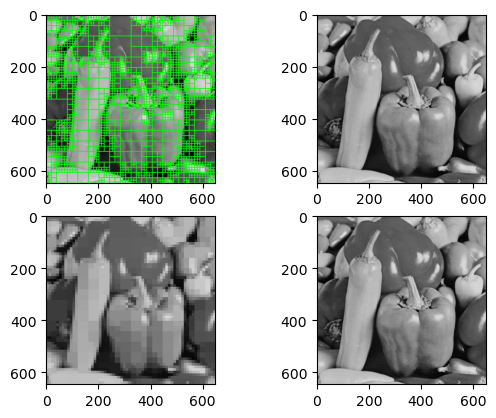

In [8]:
start_time = time.time() # measuring the time needed to split the image (used for keeping track of previous runs)

initial_region = Region(0, 0, input_image.shape[1], input_image.shape[0])
homogeneous_regions = split(input_image, initial_region, split_threshold, split_depth)

split_time = time.time() - start_time

output_with_rectangles = visualize_homogeneous_regions(input_image, homogeneous_regions)
output_with_avg_color = visualize_homogeneous_regions_with_avg_color(input_image, homogeneous_regions)

f, axarr = plt.subplots(2,2)
axarr[0, 0].imshow(cv2.cvtColor(output_with_rectangles, cv2.COLOR_BGR2RGB))
axarr[0, 1].imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
axarr[1, 0].imshow(cv2.cvtColor(output_with_avg_color, cv2.COLOR_BGR2RGB))
axarr[1, 1].imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))

# 4. Merge phase
After splitting the image into small homogeneous subregions, a merge phase is necessary to address oversegmentation and produce more meaningful results.

During the split phase, the algorithm recursively divides the image into smaller homogeneous regions. However, in areas with high variance like edges or textured regions, this process may lead to oversegmentation, creating many small, unnecessary regions that may not correspond to meaningful objects in the image.

To counteract this, the merge phase groups adjacent regions that share similar characteristics, reducing unnecessary fragmentation and improving coherence.

## The RAG (Region Adjacency Graph)
For the merge phase, we need a data structure capable of encoding both the adjacency between regions and the costs of merging two regions. The quad-tree used for the split phase is no longer suitable for this task. Instead, we use a Region Adjacency Graph (RAG). 

This data structure consists of two main components:
- **Regions**, which track the shape of each region during the merge process.
- **Links**, which maintain adjacency relationships between regions and compute the cost of merging them.

Regions are stored in a Binary Forest data structure, where leaf nodes represent the atomic regions obtained from the split operation, and parent nodes represent larger regions formed by merging two or more smaller ones. Initially, the structure consists only of disconnected leaf nodes. Then, as the algorithm progresses, parent nodes are created to form larger regions in constant time. At the end of the execution, the root nodes of each tree represents a final region to be included in the results. 

Links on the other hand are stored inside a Sorted Dictionary, a data-structure from the ```sortedcontainers``` library, that keeps links sorted by cost and allows direct access to Links in a constant time. The choice of this type of data structure is due to the two main operations that are performed on the Links: extracting the least expensive link from the list and updating the cost of the existing ones. To perform the first efficiently, an sorted list is used, while for the update, direct access to the specific links is necessary, therefore it was chosen to accompany the list with a dictionary. These two features are both included in the sorted-dictionary data structure.m

The following image shows the structure of the RAG as a whole.

![alt text](content/DS_SignalProject.png "Title")

### RAG Operations and Complexity

The main challenge in designing the RAG data structure was the fact that it has to be efficient in many aspects. The main operations taken into account was:
1) getting information about a parent region;
2) merging two regions;
3) getting the link with lowest merge cost;
4) updating link costs after a merge.

#### Getting information about a parent region

Merging two regions involves growing the region tree by creating a new ParentNode that links the two merged regions. As previously mentioned, Links are connected to atomic regions (leaf nodes). Therefore, to retrieve information about the parent region, the algorithm must climb up the tree, starting from the atomic regions, until it reaches their root node, where all relevant information about the merged region is stored.

In the worst case this operation has a linear cost with respect to the actual number of regions contained in the tree, $O(r)$, where $r$ is the number of regions. However, the average cost is logarithmic, $O(\log r)$.

#### Merging two regions
As mentioned in the previous paragraph, all the information about a parent region are stored in the root of their respective trees so, to merge two regions, we need to reach their root nodes and grow a new parent node above them. To create the new parent node, the algorithm perform the following operations:
1) update references to construct the tree data structure:
    - `newRoot.child_a: Node = child_a`
    - `newRoot.child_b: Node = child_b`
    - `newRoot.child_a.set_parent(self)`
    - `newRoot.child_b.set_parent(self)`
2) propagate the list of links connected to the two regions:
    - `newRoot.links = chain(child_a.links, child_b.links)`

    The function ```chain```, imported from the ```itertools``` library, allows to create an iterator that links the two lists in a constant time, allowing to iterate them when needed. This solution is not optimal when we need to perform random access to specific items of the list. However, this problem does not concern this algorithm since we only need to iterate over the list and there is no random access.

3) propagate other information about the child nodes: `size` is the number of atomic regions contained in a parent region, `n` is the total number of contained in the region, `value` is the sum of all the pixel contained in the regin, `mean` is the mean value of the region (computed as `value` / `n`).  
    - `newRoot.size = self.child_a.size + self.child_b.size`
    - `newRoot.n = self.child_a.n + self.child_b.n`
    - `newRoot.value = child_a.value + child_b.value`
    - `newRoot.mean = self.value / self.n`

#### Get the link with lowest merge cost

To get the link with the lowest cost is quite simple. Since all the links are stored in a sorted list we simply need to to *pop* the first element of that list. The cost this operation is $O(\log r)$ due to the internal structure of the `sorted-dict`. 

#### Updating link costs

Updating the link cost is the most expensive operation within the RAG, it consists of going through all the links connected to the two newly merged regions to update their costs. There is therefore a linear component to go through all the links and a logarithmic component to update the cost of link (remove and reinsert from the sorted-dict). The final cost is therefore $O(n\log r)$, where $n$ is the total number of links and $r$ is the total number of regions.

> To improve efficiency during this operation, the list of links is propagated from child nodes to parent nodes during the merge process. This avoids having to visit the entire tree to obtain the complete list of links, which would have a cost related to the number of tree-nodes rather than the actual number of links.

The link cost is obtained by computing the difference between the **variance of the merged region**, computed using the combined variance formula,

$$
\mu_{TOT} = \frac{N_1 \mu_1 + N_2 \mu_2}{N_1 + N_2},\quad\sigma^2_{TOT} = \frac{N_1 \left( \sigma_1^2 + (\mu_1 - \mu)^2 \right) + N_2 \left( \sigma_2^2 + (\mu_2 - \mu)^2 \right)}{N_1 + N_2}
$$

and the **variance of the regions before the merge**, computed as a weighted mean between the two variances.

$$
\sigma^2_{REG} = \frac{N_1 \cdot \sigma_1^2 + N_2 \cdot \sigma_2^2}{N_1 + N_2}
$$

The cost is finally computed as follow:

$$
C = \sigma^2_{TOT} - \sigma^2_{REG}
$$

where:
- $N_1, \mu_1, \sigma_1^2$ are respectively the number of pixel, the mean and the variance of the first region, 
- $N_2, \mu_2, \sigma_2^2$ are respectively the number of pixel, the mean and the variance of the second region,
- $\mu_{TOT}, \sigma^2_{TOT}$ are the mean and variance of the merged region.

## The merge algorithm
In the previous chapter we discussed about the RAG data structure, showing its main operations and design challenges. It's now the time to put all things together in the merge algorithm.

Below is a summarized version of the pseudocode for the merge phase. The implementation details of the most critical steps, along with the RAG data structure, will be described in the next section.

```
MERGE(merge_threshold):
    RAG initialization (links and initial regions)
    result = []
    WHILE RAG.links NOT EMPTY: 
        L = RAG.get_lowest_cost_link()
        threshold = mergeThreshold / linkSize
        IF link_variance > threshold: 
            result.append(L)
        ELSE:
            link.merge()
            RAG.refresh_links()
    RETURN get_all_regions(result)
```

The algorithm begins with RAG initialization, that consists in creating a leaf node for every region and then to create links between adjacent regions. This procedure is made by checking all possible pair of regions and comparing their coordinates in the image. Therefore this operation has a cost of $n^2$, where $n$ is the number of regions.

After RAG initialization, the main process consists of iterating until no more links can be merged. In each iteration, the algorithm selects from the RAG the link with the lowest merge cost (i.e., the smallest loss of homogeneity). If the variance $𝑉_𝐿$ of the link is below a given threshold $𝑆_𝐿$, the regions are merged. The computational cost of this loop is linear with respect to the number of links $n$, this cost has to be multiplied by the cost of each iteration, we'll se it at the end of this paragraph. 

<blockquote>
Note that in this case the threshold is not a fixed value as in the split part, in this case it is normalized based on the size of the regions to merge. This is due to the fact that the variance is on average higher for smaller regions that would therefore be difficult to merge.

$$
threshold = mergeThreshold / linkSize
$$
</blockquote>

After the regions are merged, it is necessary to update the cost of the other links pointing to each of the two regions (refresh_links). Additionally, some links may need to be deleted if they connect two atomic regions that are part of the same larger region. 

If the link cost is instead higher than the threshold, its regions cannot be merged anymore. It is then added to the result list, which is used at the end to obtain the final regions list.

- the complexity of getting the link with lower cost is $log(r)$, where $r$ id the total number of regions;
- `result.append()` is made in a constant time;
- `link.merge()`is made in a constant time;
- refreshing the links has a cost of $n\log(r)$, where $n$ is the number of links and $r$ is the number of regions.

The final complexity of the merge algorithm is therefore $n^2\log(r)$.



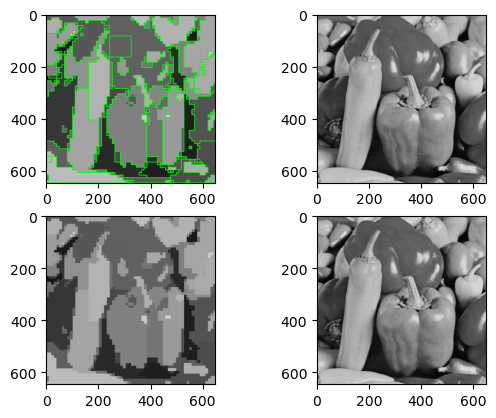

In [9]:
start_time = time.time() # measuring the time needed to merge the regions (used for keeping track of previous runs)

regions = merge(homogeneous_regions, threshold=merge_threshold)

merge_time = time.time() - start_time

# saving the image to the disk keeping track of the parameters used
image_with_borders = visualize_regions_with_borders(input_image, regions)
image_with_mean_color = visualize_regions_with_avg_color(input_image, regions)

# save_image(image_with_borders, image_path, split_depth, split_threshold, merge_threshold, split_time + merge_time) 

f, axarr = plt.subplots(2,2)
axarr[0, 0].imshow(cv2.cvtColor(image_with_borders, cv2.COLOR_BGR2RGB))
axarr[0, 1].imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
axarr[1, 0].imshow(cv2.cvtColor(image_with_mean_color, cv2.COLOR_BGR2RGB))
axarr[1, 1].imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))

# 5. Results
The image above represents the results obtained after performing the merge operation. Overall, the algorithm is able to segment images of different types with good accuracy and in a reasonably short time.

One of the most challenging aspects in the development of this algorithm was to make it efficient, the first versions were very slow and performed many useless operations. Over time, the data structures have been improved, reducing the complexity of certain operations and making the algorithm much faster overall.

The main negative aspects of this algorithm are the high memory usage and the fact that it depends a lot on the parameters with which it is executed; parameters that work well with images may not give the same results with others.

To conclude, below is a summary of some executions of the algorithm with different parameters and different types of images, in which it is possible to understand how the results vary based on the parameters that are passed.

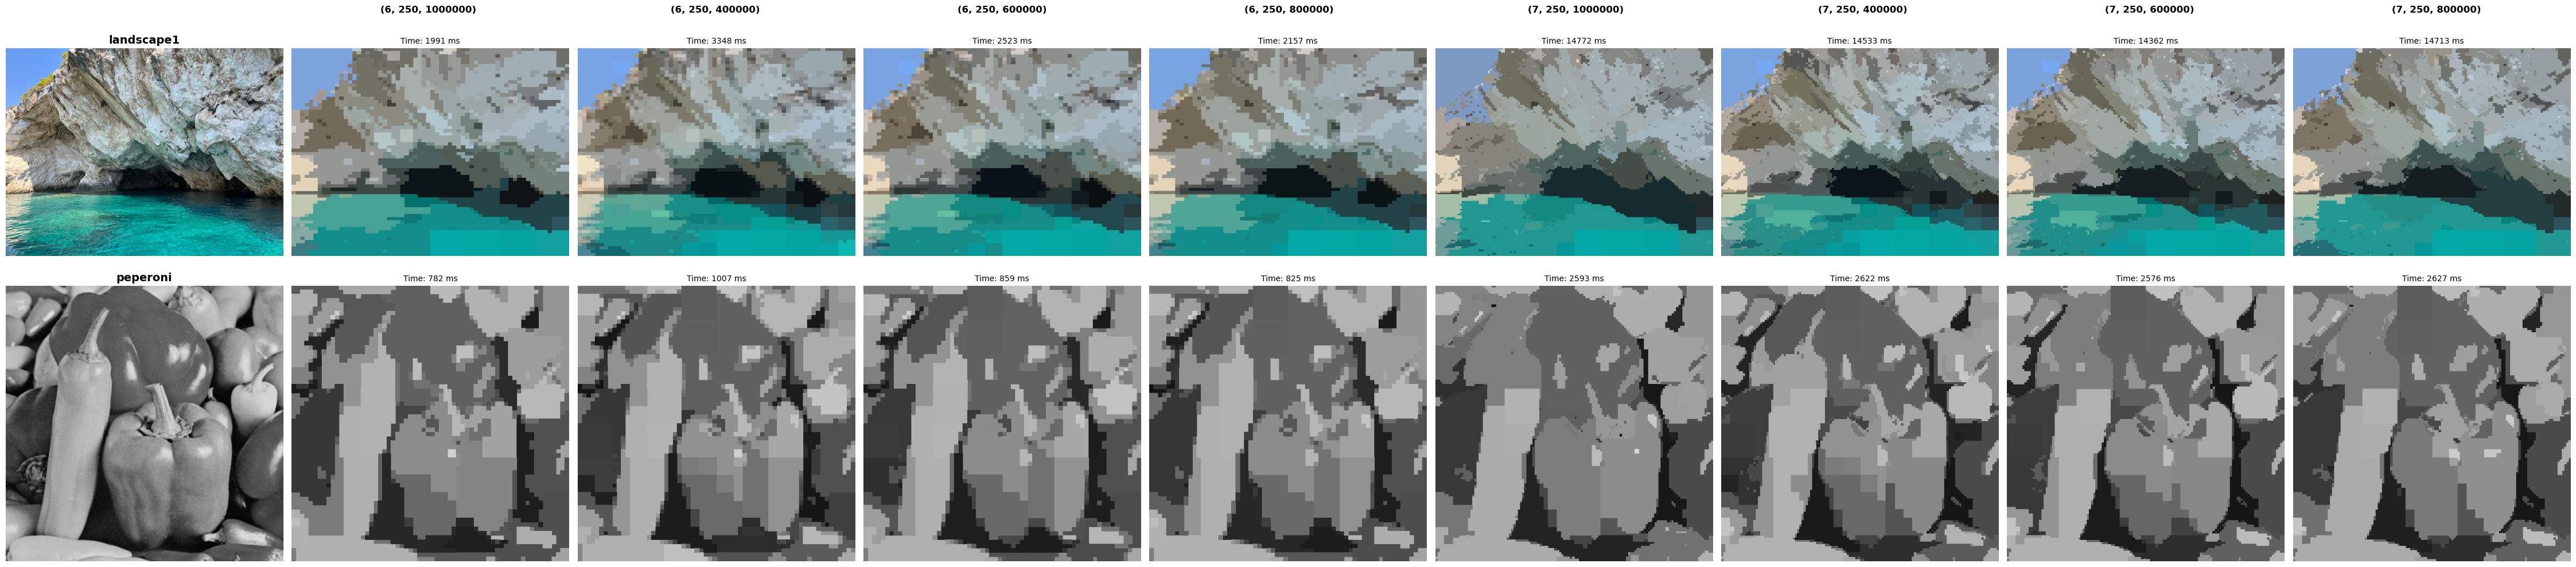

In [10]:
plot_previous_runs(0.167)